### Try to make sense of the rectified image to extract out the SA signa

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii, fits
from matplotlib.gridspec import GridSpec
from scipy import interpolate
from astropy.visualization import MinMaxInterval, AsinhStretch, HistEqStretch, ImageNormalize
%matplotlib inline

In [2]:
# load in a rectified image
path = '../191008/rectified/'
source = 'img1-2'

hdu1 = fits.open(path+source+'.fits')
data1 = hdu1[0].data
hd1 = hdu1[0].header
hdu1.close()

In [3]:
hd1

SIMPLE  =                    T / Written by IDL:  Wed Aug  2 16:36:48 2023      
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 1995 /                                                
NAXIS2  =                 2446 /                                                
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2023-08-03'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    

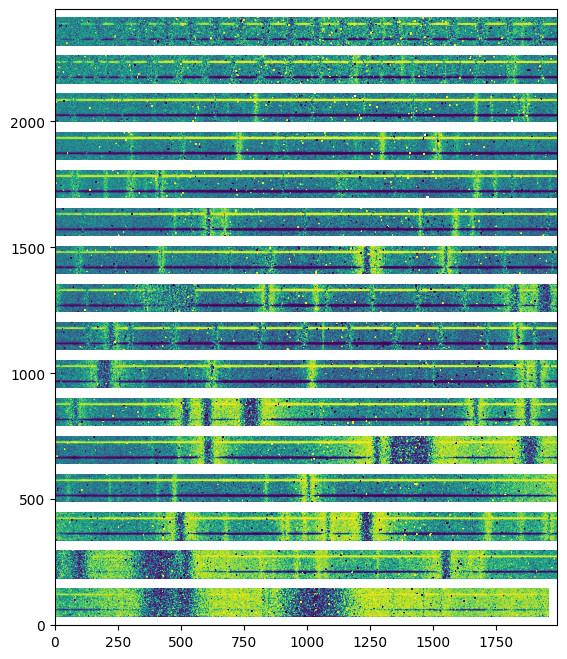

In [4]:
# plot the image to compare with xspextool
fig, ax = plt.subplots(figsize=(8, 8))
#norm = ImageNormalize(data1, interval=MinMaxInterval(), stretch=AsinhStretch(0.3))
norm = ImageNormalize(data1, interval=MinMaxInterval(), stretch=HistEqStretch(data1))
ax.imshow(data1, origin='lower', norm=norm)

In [5]:
data1[1130, 726]

-0.4003799557685852

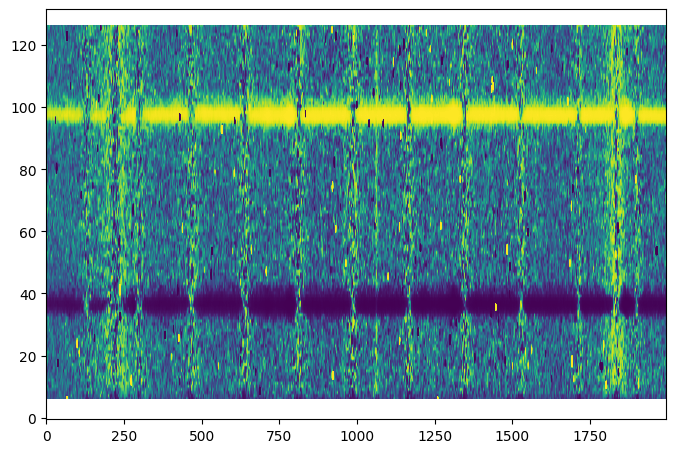

In [6]:
# plot a given order (between 99 and 114)
fig, ax = plt.subplots(figsize=(8, 8))
j1 = 29           # starting point of first order
dj_AB = 122       # width of each order
dj_blank = 29     # gap between orders
dj_plot = 5       # cosmetic gap to make the plot look nice

order = 106
j0 = j1 + (dj_AB + dj_blank) * (order - 99)
ax.imshow(data1[j0-dj_plot:j0+dj_AB+dj_plot, :], origin='lower', norm=norm, aspect=10)

In [7]:
# load in the wavecal data and try to make sense of it
path = '../191008/cal/'
calfile = 'wavecal1-28'

hdu2 = fits.open(path+calfile+'.fits')
hdu2.info()

Filename: ../191008/cal/wavecal1-28.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   ()      
  1                1 ImageHDU         7   (2048, 2048)   float64   
  2                1 ImageHDU         7   (2048, 2048)   float64   
  3                1 ImageHDU         8   (1965, 122, 2)   float64   
  4                1 ImageHDU         8   (1996, 122, 2)   float64   
  5                1 ImageHDU         8   (1996, 122, 2)   float64   
  6                1 ImageHDU         8   (1996, 122, 2)   float64   
  7                1 ImageHDU         8   (1996, 122, 2)   float64   
  8                1 ImageHDU         8   (1996, 122, 2)   float64   
  9                1 ImageHDU         8   (1996, 122, 2)   float64   
 10                1 ImageHDU         8   (1996, 122, 2)   float64   
 11                1 ImageHDU         8   (1996, 122, 2)   float64   
 12                1 ImageHDU         8   (1996, 122, 2)   float64   
 13       

In [10]:
wc_hd = hdu2[0].header
wc_hd

SIMPLE  =                    T /  Primary Header created by MWRFITS v1.14       
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /  Extensions may be present                     
IRAFNAME= 'wavecal1-28.fits'   / Filename                                       
FLATNAME= 'flat29-33.fits'     / Associated flat field frame                    
ORDERS  = '99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114' /  Or
NORDERS =                   16 /  Number of orders identified                   
EXTTYPE = '2D      '           / Extraction type                                
WCTYPE  = '2DXD    '           / Wavelength calibration type                    
WAVEFMT = '(D8.6)  '           / Wavelength format statement                    
SPATFMT = '(F+7.3) '           / Angle format statement                         
RMS     = '0.020   '        

In [45]:
# translation of mc_readwavecal

orders = wc_hd['ORDERS'].split(',')
norders = wc_hd['NORDERS']
wctype = wc_hd['WCTYPE']
wavefmt = wc_hd['WAVEFMT']
spatfmt = wc_hd['SPATFMT']

# translation of mc_fxpar
wdisp = []
c = wc_hd.cards
for i, c1 in enumerate(c):
    if c1[0][0:4] == 'DISP':
        wdisp.append([c1[0], wc_hd[i]])

In [86]:
i = 15
tmp = hdu2[3+i].data
tmp.shape

(2, 122, 1996)

In [96]:
# this is actually all we need
wl = tmp[0, 0, 1:]
slitpos = tmp[0, 1:, 0]
print(wl)
print(slitpos)

[4.50922887 4.5092495  4.50927012 ... 4.54729133 4.54730902 4.54732671]
[ 0.     0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125
  1.25   1.375  1.5    1.625  1.75   1.875  2.     2.125  2.25   2.375
  2.5    2.625  2.75   2.875  3.     3.125  3.25   3.375  3.5    3.625
  3.75   3.875  4.     4.125  4.25   4.375  4.5    4.625  4.75   4.875
  5.     5.125  5.25   5.375  5.5    5.625  5.75   5.875  6.     6.125
  6.25   6.375  6.5    6.625  6.75   6.875  7.     7.125  7.25   7.375
  7.5    7.625  7.75   7.875  8.     8.125  8.25   8.375  8.5    8.625
  8.75   8.875  9.     9.125  9.25   9.375  9.5    9.625  9.75   9.875
 10.    10.125 10.25  10.375 10.5   10.625 10.75  10.875 11.    11.125
 11.25  11.375 11.5   11.625 11.75  11.875 12.    12.125 12.25  12.375
 12.5   12.625 12.75  12.875 13.    13.125 13.25  13.375 13.5   13.625
 13.75  13.875 14.    14.125 14.25  14.375 14.5   14.625 14.75  14.875
 15.   ]


In [104]:
# the image information shows pixels in the unrectified image at each wavelength and slit offset
# but we don't need this (which would be going backwards!)
sgrid = tmp[0,1:,1:]
sgrid

array([[  45.85393062,   46.85475925,   47.85558754, ..., 2038.64961778,
        2039.6495775 , 2040.64953688],
       [  45.8190062 ,   46.81982052,   47.82063451, ..., 2038.60154751,
        2039.60150872, 2040.60146958],
       [  45.7842183 ,   46.78501833,   47.78581803, ..., 2038.5536114 ,
        2039.55357407, 2040.55353639],
       ...,
       [  42.67433182,   43.67359282,   44.6728541 , ..., 2033.90131625,
        2034.90126363, 2035.90121123],
       [  42.65550889,   43.65475766,   44.65400671, ..., 2033.86905173,
        2034.86899739, 2035.86894327],
       [  42.63682269,   43.63605923,   44.63529606, ..., 2033.83692137,
        2034.83686529, 2035.83680941]])

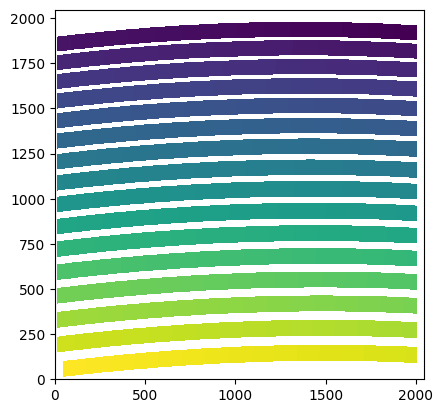

In [22]:
# this shows the wavelength at each pixel but in the non-rectified data :(
im1 = hdu2[1].data
hd1 = hdu2[1].header
plt.imshow(im1, origin='lower')

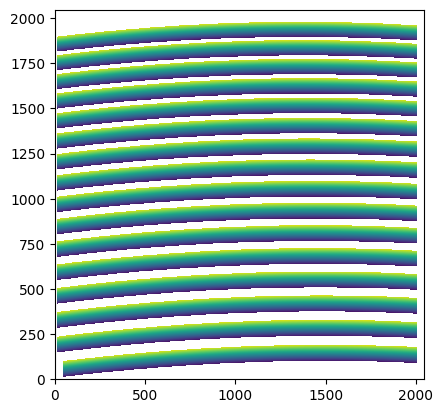

In [23]:
# this shows the slit offset at each pixel but in the non-rectified data :(
im2 = hdu2[2].data
hd2 = hdu2[2].header
plt.imshow(im2, origin='lower')

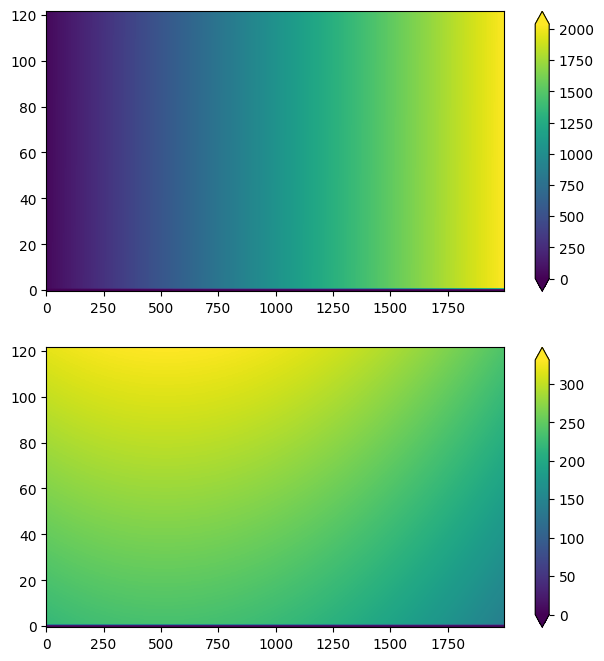

In [59]:
order = 100

# these are the x-coordinates of lines of constant wavelength
wavecal = hdu2[3+order-99].data
fig = plt.figure(figsize=(8, 8))
ax0 = fig.add_subplot(211)
im0 = ax0.imshow(wavecal[0, :, :], origin='lower', aspect=10)
cbar = fig.colorbar(im0, extend='both', shrink=1.0, ax=ax0)

# y-coordinates???
ax1 = fig.add_subplot(212)
im1 = ax1.imshow(wavecal[1, :, :], origin='lower', aspect=10)
cbar = fig.colorbar(im1, extend='both', shrink=1.0, ax=ax1)

In [ ]:
path = '../191008/raw/'
source = 'icm.2019B113.191008.fname.00001.a'

hdu3 = fits.open(path+source+'.fits')
data3 = hdu3[0].data
hd3 = hdu3[0].header
hdu3.close()

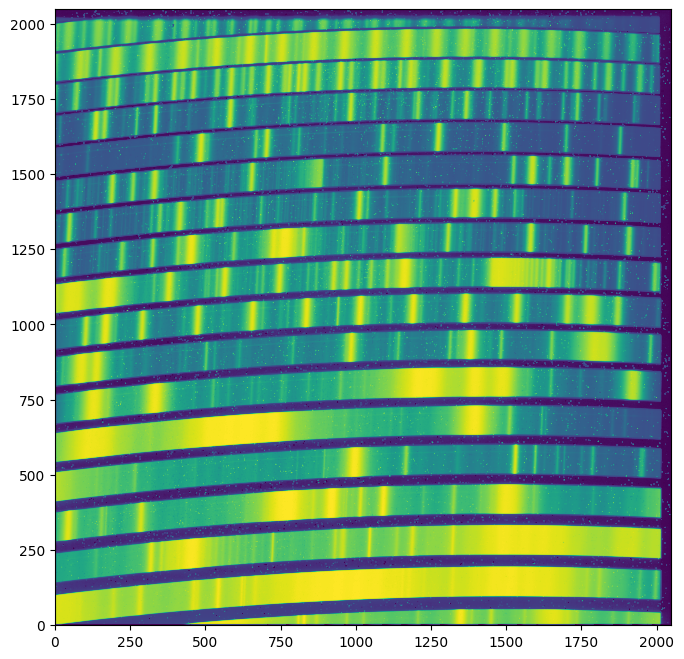

In [ ]:
# plot the image to compare with xspextool
fig, ax = plt.subplots(figsize=(8, 8))
norm = ImageNormalize(data3, interval=MinMaxInterval(), stretch=HistEqStretch(data3))
ax.imshow(data3, origin='lower', norm=norm)